<a href="https://colab.research.google.com/github/escorpio11/programa-python/blob/main/UNI/VISUALIZACION_DE_DATOS/M%C3%93DULO_4_Matplotlib_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

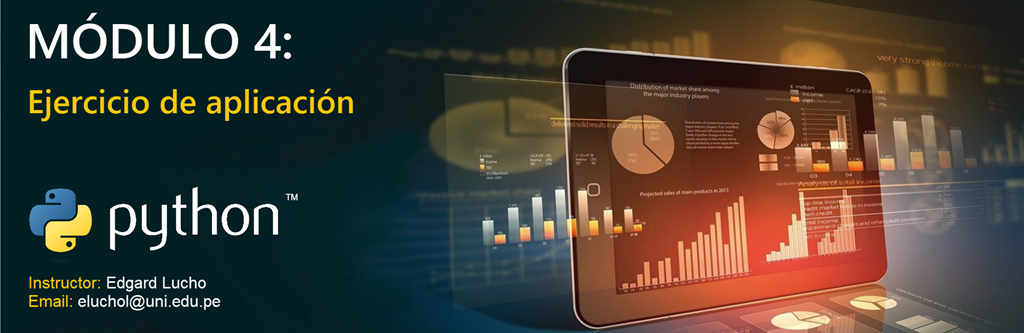

<table width='99%'>
<tr>
<td bgcolor='#306998'>

# **<font color="#FFFFFF">Módulo 4: Matplotlib</font>**

</td>
</tr>
</table>

<table width='99%'>
<tr>
<td bgcolor='#FFD43B'>

## **<font color="#000000">Carga de los datos</font>**

</td>
</tr>
</table>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd

df_DimCurrency = pd.read_excel('drive/MyDrive/db/empresa.xlsx', sheet_name='DimCurrency')
df_DimPromotion = pd.read_excel('drive/MyDrive/db/empresa.xlsx', sheet_name='DimPromotion')
df_DimEmployee = pd.read_excel('drive/MyDrive/db/empresa.xlsx', sheet_name='DimEmployee')
df_DimGeography = pd.read_excel('drive/MyDrive/db/empresa.xlsx', sheet_name='DimGeography')
df_DimProduct = pd.read_excel('drive/MyDrive/db/empresa.xlsx', sheet_name='DimProduct')
df_DimProductCategory = pd.read_excel('drive/MyDrive/db/empresa.xlsx', sheet_name='DimProductCategory')
df_DimProductSubcategory = pd.read_excel('drive/MyDrive/db/empresa.xlsx', sheet_name='DimProductSubcategory')
df_DimSalesTerritory = pd.read_excel('drive/MyDrive/db/empresa.xlsx', sheet_name='DimSalesTerritory')
df_FactResellerSales = pd.read_excel('drive/MyDrive/db/empresa.xlsx', sheet_name='FactResellerSales')

fecha_min = df_FactResellerSales['OrderDate'].min()
fecha_max = df_FactResellerSales['OrderDate'].max()

fechas = pd.date_range(fecha_min, fecha_max, freq='D')

df_DimCalendario = pd.DataFrame({'Fecha': fechas})

df_DimCalendario['Año'] = df_DimCalendario['Fecha'].dt.year
df_DimCalendario['Semestre'] = np.where(df_DimCalendario['Fecha'].dt.month <= 6, 'S-1', 'S-2')
df_DimCalendario['Trimestre'] = ((df_DimCalendario['Fecha'].dt.month -1) // 3 + 1).apply(lambda x: f'T-{x}')
df_DimCalendario['Mes'] = df_DimCalendario['Fecha'].dt.month_name()
df_DimCalendario['MesAbr'] = df_DimCalendario['Fecha'].dt.month_name().str[:3]
df_DimCalendario['MesNum'] = df_DimCalendario['Fecha'].dt.month
df_DimCalendario['SemAño'] = df_DimCalendario['Fecha'].dt.isocalendar().week
df_DimCalendario['Dia'] = df_DimCalendario['Fecha'].dt.day_name()
df_DimCalendario['DiaAbr'] = df_DimCalendario['Fecha'].dt.day_name().str[:3]
df_DimCalendario['DiaNumSem'] = df_DimCalendario['Fecha'].dt.dayofweek + 1
df_DimCalendario['DiaMes'] = df_DimCalendario['Fecha'].dt.day

df_categoria_subcategoria = pd.merge(df_DimProductCategory, df_DimProductSubcategory, on='ProductCategoryKey', how='inner').copy()
df_categoria_subcategoria_producto = pd.merge(df_categoria_subcategoria, df_DimProduct, on='ProductSubcategoryKey', how='inner').copy()
df_categoria_subcategoria_producto = df_categoria_subcategoria_producto.rename(columns={'StartDate': 'FechaIniPrd', 'EndDate': 'FechaFinPrd'}).copy()

df_DimPromotion['MaxQty'] = df_DimPromotion['MaxQty'].fillna(99999)

df_FactVentas = pd.merge(df_FactResellerSales, df_DimPromotion, on='PromotionKey', how='inner').copy()
df_FactVentas = pd.merge(df_FactVentas, df_categoria_subcategoria_producto, on='ProductKey', how='inner').copy()
df_FactVentas = pd.merge(df_FactVentas, df_DimCalendario, left_on='OrderDate', right_on='Fecha', how='inner').copy()
df_FactVentas = pd.merge(df_FactVentas, df_DimSalesTerritory, on='SalesTerritoryKey',  how='inner').copy()


df_FactVentas['Costos'] = df_FactVentas['OrderQuantity'] * df_FactVentas['ProductStandardCost']
df_FactVentas['Ventas'] = df_FactVentas['OrderQuantity'] * df_FactVentas['UnitPrice'] * (
    1
    -
    np.where
    (
        (df_FactVentas['OrderDate'] >= df_FactVentas['StartDate']) &
        (df_FactVentas['OrderDate'] <= df_FactVentas['EndDate']) &
        (df_FactVentas['OrderQuantity'] >= df_FactVentas['MinQty']) &
        (df_FactVentas['OrderQuantity'] <= df_FactVentas['MaxQty']),
        df_FactVentas['DiscountPct'],
        df_FactVentas['UnitPriceDiscountPct']
    )
    )
df_FactVentas['Utilidad'] = df_FactVentas['Ventas'] - df_FactVentas['Costos']
df_FactVentas['PorcentajeMargen'] = (df_FactVentas['Utilidad'] / df_FactVentas['Ventas']) * 100


<table width='99%'>
<tr>
<td bgcolor='#FFD43B'>

## **<font color="#000000">Gráficos de columnas apiladas</font>**

</td>
</tr>
</table>

In [ ]:
año = 2012

df_mes_year_costos = df_FactVentas[df_FactVentas['Año'] == año].groupby(['Año', 'MesNum', 'MesAbr'])['Costos'].sum().reset_index()
df_mes_year_costos.columns = ['Año', 'Mes', 'MesAbr', 'Costos']
df_mes_year_costos['MesAño'] = df_mes_year_costos['MesAbr'].astype(str) + '-' + df_mes_year_costos['Año'].astype(str)

df_mes_year_ventas = df_FactVentas[df_FactVentas['Año'] == año].groupby(['Año', 'MesNum', 'MesAbr'])['Ventas'].sum().reset_index()
df_mes_year_ventas.columns = ['Año', 'Mes', 'MesAbr', 'Ventas']
df_mes_year_ventas['MesAño'] = df_mes_year_costos['MesAbr'].astype(str) + '-' + df_mes_year_costos['Año'].astype(str)

df_mes_year_utilidad = df_FactVentas[df_FactVentas['Año'] == año].groupby(['Año', 'MesNum', 'MesAbr'])['Utilidad'].sum().reset_index()
df_mes_year_utilidad.columns = ['Año', 'Mes', 'MesAbr', 'Utilidad']
df_mes_year_utilidad['MesAño'] = df_mes_year_costos['MesAbr'].astype(str) + '-' + df_mes_year_costos['Año'].astype(str)
df_mes_year_utilidad

,Año,Mes,MesAbr,Utilidad,MesAño
0,2012,1,Jan,132365.014851,Jan-2012
1,2012,2,Feb,149472.966671,Feb-2012
2,2012,3,Mar,77636.624725,Mar-2012
3,2012,4,Apr,134695.960085,Apr-2012
4,2012,5,May,111704.722717,May-2012
5,2012,6,Jun,50156.453606,Jun-2012
6,2012,7,Jul,76762.811243,Jul-2012
7,2012,8,Aug,66405.146504,Aug-2012
8,2012,9,Sep,82941.307180,Sep-2012
9,2012,10,Oct,115206.588635,Oct-2012


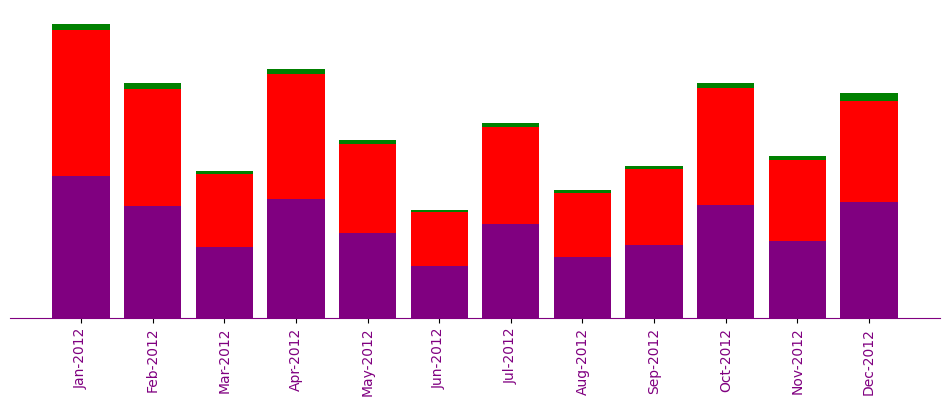

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

barra1 = plt.bar(df_mes_year_costos['MesAño'], df_mes_year_costos['Costos'], color='purple', label='Costos')
barra2 = plt.bar(df_mes_year_costos['MesAño'], df_mes_year_ventas['Ventas'], color='red', label='Ventas', bottom=df_mes_year_costos['Costos'])
barra3 = plt.bar(df_mes_year_costos['MesAño'], df_mes_year_utilidad['Utilidad'], color='green', label='Utilidad', bottom = df_mes_year_costos['Costos'] + df_mes_year_ventas['Ventas'])

plt.gca

plt.xticks(color='purple', rotation=90)
plt.yticks([])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('purple')

plt.show()

In [ ]:
año = 2012

df_ventas_año_mes = df_FactVentas[df_FactVentas['Año'] == año].groupby(['Año', 'MesNum', 'MesAbr']).agg({'Ventas': 'sum', 'Costos': 'sum'}).reset_index()

df_ventas_año_mes.head(50)


,Año,MesNum,MesAbr,Ventas,Costos
0,2012,1,Jan,3.601191e+06,3.468826e+06
1,2012,2,Feb,2.885359e+06,2.735886e+06
2,2012,3,Mar,1.802154e+06,1.724518e+06
3,2012,4,Apr,3.053816e+06,2.919120e+06
4,2012,5,May,2.185213e+06,2.073508e+06
5,2012,6,Jun,1.317542e+06,1.267385e+06
6,2012,7,Jul,2.384847e+06,2.308084e+06
7,2012,8,Aug,1.563955e+06,1.497550e+06
8,2012,9,Sep,1.865278e+06,1.782337e+06
9,2012,10,Oct,2.880753e+06,2.765546e+06


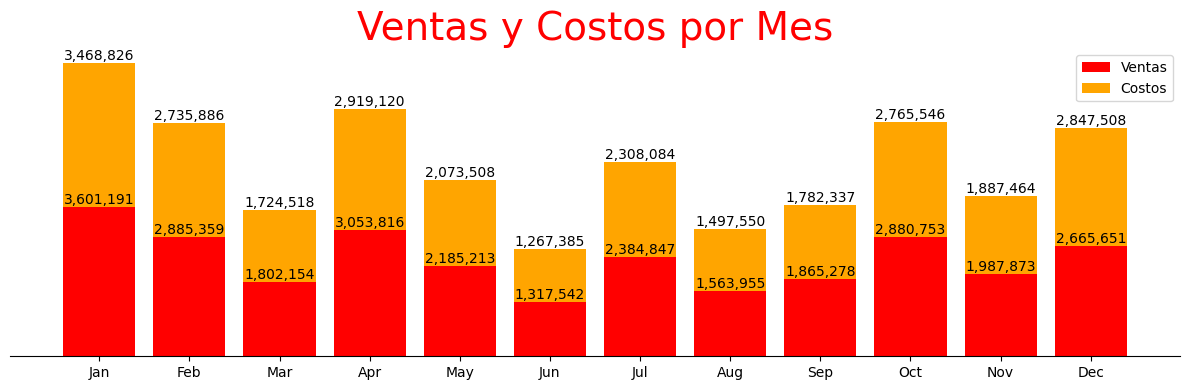

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(df_ventas_año_mes['MesAbr'], df_ventas_año_mes['Ventas'], color='red', label='Ventas')
ax.bar(df_ventas_año_mes['MesAbr'], df_ventas_año_mes['Costos'], color='orange', label='Costos', bottom=df_ventas_año_mes['Ventas'])

plt.xticks(color='black', rotation=0)

ax.set_title('Ventas y Costos por Mes', color='red', fontsize=28)
ax.legend()
#ax.set_xlabel('Mes')
#ax.set_ylabel('Monto')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('black')
plt.yticks([])

for i in range(len(df_ventas_año_mes)):
    ax.text(i, df_ventas_año_mes['Ventas'][i], f"{df_ventas_año_mes['Ventas'][i]:,.0f}", ha='center', va='bottom', color='black')
    ax.text(i, df_ventas_año_mes['Ventas'][i] + df_ventas_año_mes['Costos'][i], f"{df_ventas_año_mes['Costos'][i]:,.0f}", ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()



<table width='99%'>
<tr>
<td bgcolor='#306998'>

### **<font color="#FFFFFF">Ventas por categoría del producto y año</font>**

</td>
</tr>
</table>

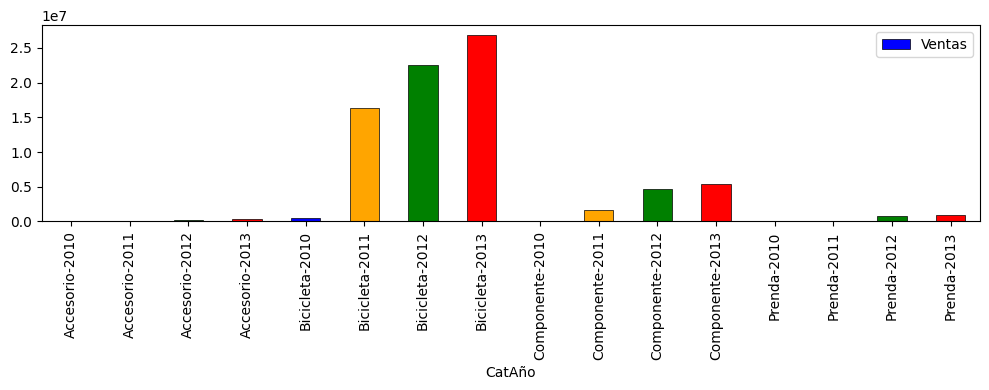

In [ ]:
df_categoria_año = df_FactVentas.groupby(['SpanishProductCategoryName', 'Año'])['Ventas'].sum().reset_index()

df_categoria_año['CatAño'] = df_categoria_año['SpanishProductCategoryName'].astype(str) + '-' + df_categoria_año['Año'].astype(str)

colores = ['blue', 'orange', 'green', 'red']

df_categoria_año.plot(kind='bar', x='CatAño', y='Ventas', color=colores, figsize=(10, 4), edgecolor='black', linewidth=0.5)
plt.xticks(color='black', rotation=90)
plt.tight_layout()
plt.show()

<table width='99%'>
<tr>
<td bgcolor='#306998'>

### **<font color="#FFFFFF">Utilidad por subcategoria del producto y trimestre</font>**

</td>
</tr>
</table>

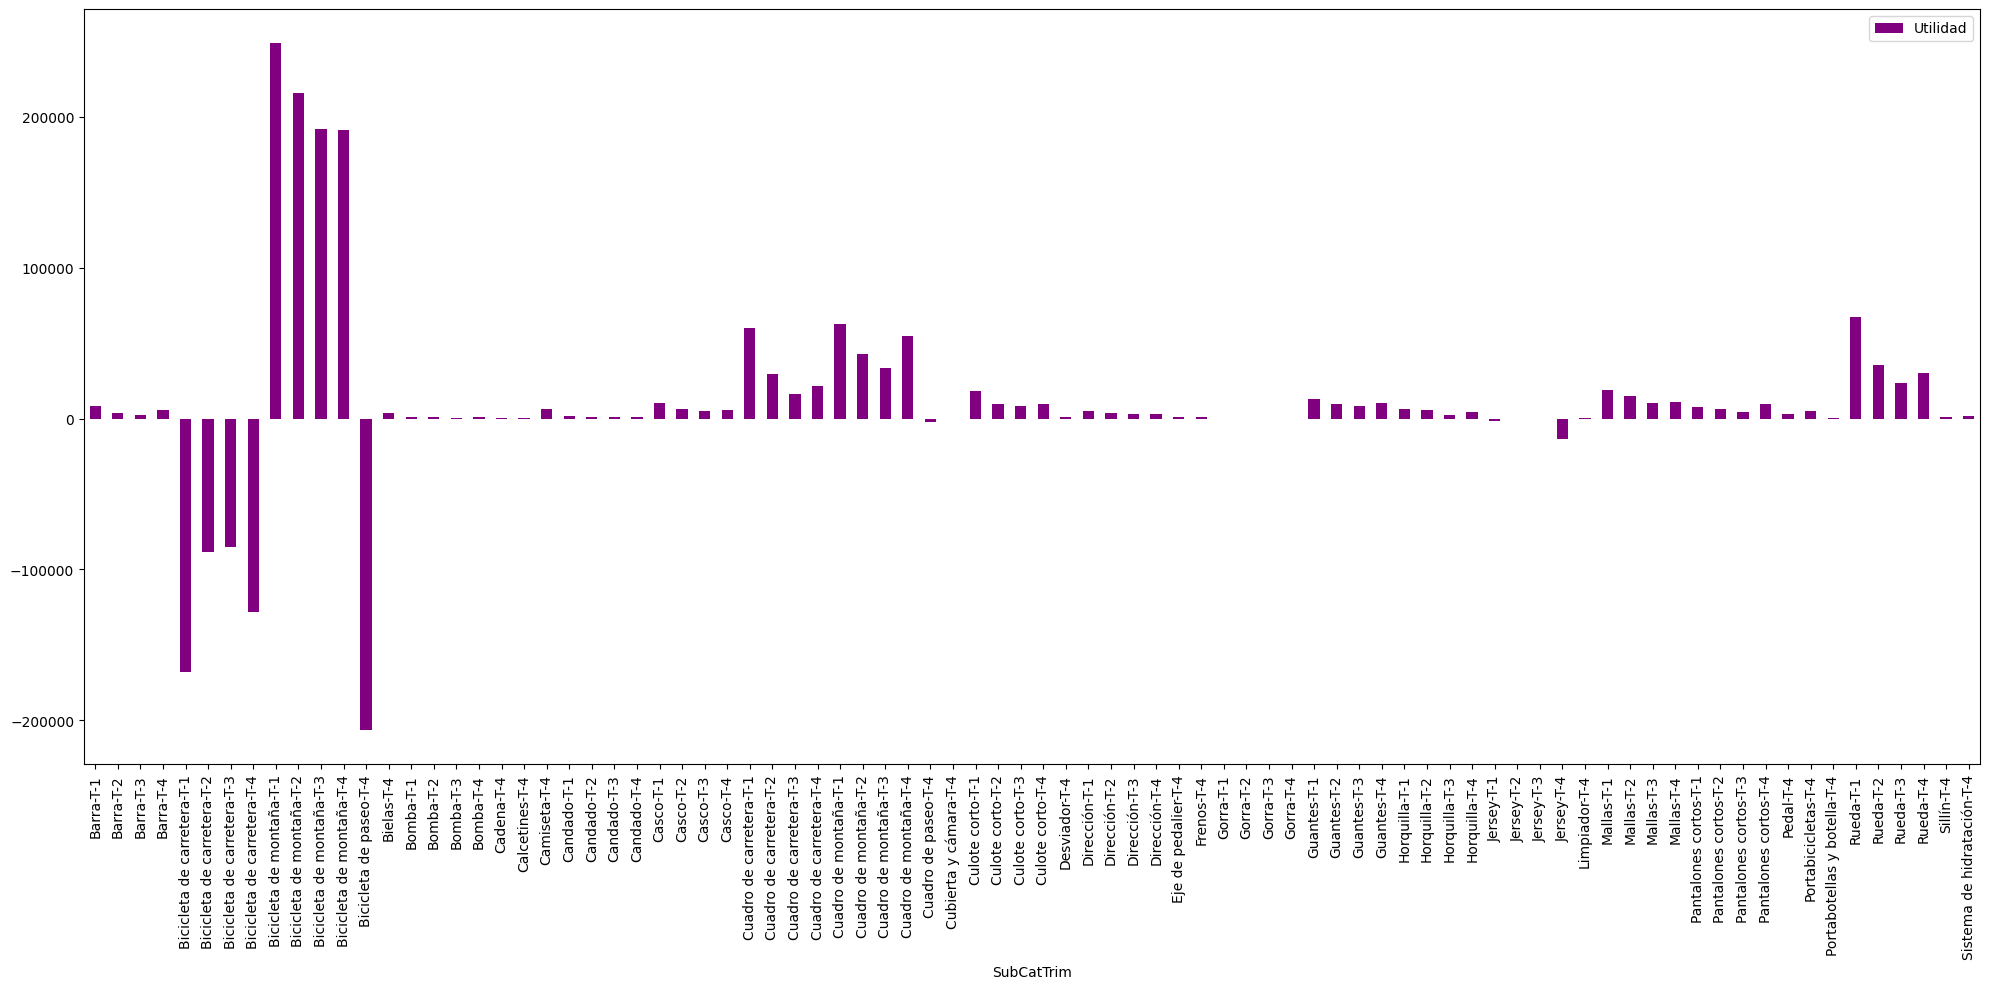

In [ ]:
año = 2012

df_subcategoria_trimestre = df_FactVentas[df_FactVentas['Año'] == año].groupby(['SpanishProductSubcategoryName', 'Trimestre'])['Utilidad'].sum().reset_index()
df_subcategoria_trimestre['SubCatTrim'] = df_subcategoria_trimestre['SpanishProductSubcategoryName'].astype(str) + '-' + df_subcategoria_trimestre['Trimestre'].astype(str)

df_subcategoria_trimestre.plot(kind='bar', x='SubCatTrim', y='Utilidad', color='purple', figsize=(20, 10))
plt.xticks(color='black', rotation=90)
plt.tight_layout()
plt.show()


<table width='99%'>
<tr>
<td bgcolor='#306998'>

### **<font color="#FFFFFF">Costos por continente y año</font>**

</td>
</tr>
</table>

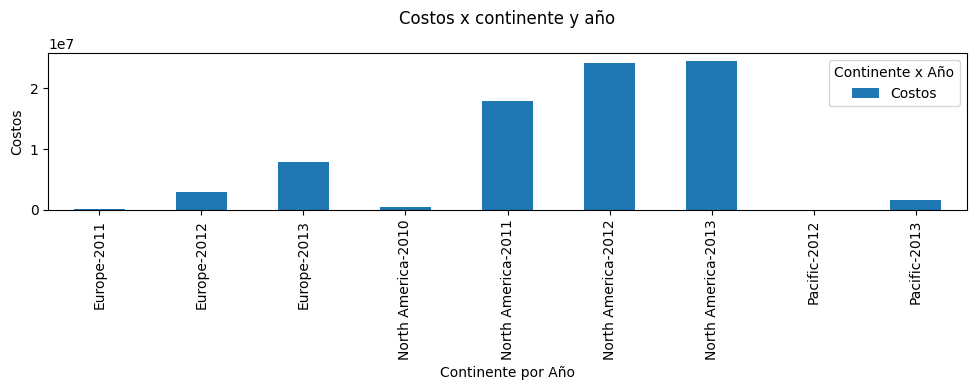

In [ ]:
df_costos_continente_año = df_FactVentas.groupby(['SalesTerritoryGroup', 'Año'])['Costos'].sum().reset_index()
df_costos_continente_año['ContinenteAño'] = df_costos_continente_año['SalesTerritoryGroup'].astype(str) + '-' + df_costos_continente_año['Año'].astype(str)
#df_costos_continente_año.plot(kind='bar', x='ContinenteAño', y='Costos', colormap='Pastel1', figsize=(10, 4))
df_costos_continente_año.plot(kind='bar', x='ContinenteAño', y='Costos', colormap='tab10', figsize=(10, 4))
plt.title('Costos x continente y año\n')
plt.xticks(color='black', rotation=90)
plt.xlabel('Continente por Año')
plt.ylabel('Costos')
plt.legend(title='Continente x Año')
plt.tight_layout()
plt.show()


<table width='99%'>
<tr>
<td bgcolor='#FFD43B'>

## **<font color="#000000">Gráficos de Sectores (Pastel)</font>**

</td>
</tr>
</table>

Los gráficos de sectores, también conocidos como gráficos de pastel (o gráficos de torta), son una forma de visualización de datos que se utiliza para mostrar la proporción o la distribución de categorías dentro de un conjunto de datos.

En un gráfico de pastel, cada sector (o "porción") representa una categoría y su tamaño es proporcional a la cantidad que representa en relación con el total.

<table width='99%'>
<tr>
<td bgcolor='#306998'>

### **<font color="#FFFFFF">Características</font>**

</td>
</tr>
</table>

>* **Proporciones**: Cada sector muestra la proporción que representa cada categoría respecto al total.
>* **Visualización Intuitiva**: Son útiles para visualizar datos categóricos y son fáciles de entender a simple vista.
>* **Limitaciones**: No son ideales para comparar categorías similares o para mostrar cambios a lo largo del tiempo, ya que pueden ser difíciles de interpretar en tales casos.

In [ ]:
df_categoria_ventas = df_FactVentas.groupby(['SpanishProductCategoryName'])['Ventas'].sum().reset_index()
df_categoria_ventas.columns = ['Categoría', 'Ventas']
df_categoria_ventas.head(50)


,Categoría,Ventas
0,Accesorio,5.712979e+05
1,Bicicleta,6.630238e+07
2,Componente,1.179908e+07
3,Prenda,1.777841e+06


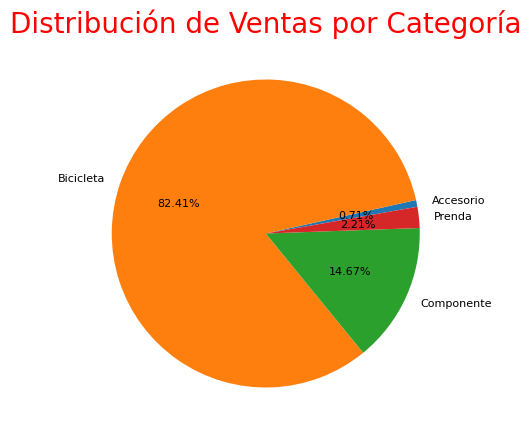

In [ ]:
plt.figure(figsize=(5, 5))
plt.pie(df_categoria_ventas['Ventas'],
        labels=df_categoria_ventas['Categoría'],
        autopct='%1.2f%%',
        textprops={'fontsize':8, 'color':'black'},
        startangle=10)
plt.title('Distribución de Ventas por Categoría', color='red', fontsize=20)
plt.show()

In [ ]:

ventas = sum(df_categoria_ventas['Ventas'])
categorias = df_categoria_ventas['Categoría']

num_colores = len(categorias)
colores_purpura = plt.cm.Purples(np.linspace(0.4, 1, num_colores))

df_categoria_ventas['Porcentajes'] = df_categoria_ventas['Ventas'] / ventas * 100
df_categoria_ventas['Etiqueta'] = [f'{cat}: {ven:,.0f} ({porc:.2f}%)' for cat, ven, porc in zip(df_categoria_ventas['Categoría'], df_categoria_ventas['Ventas'], df_categoria_ventas['Porcentajes'])]






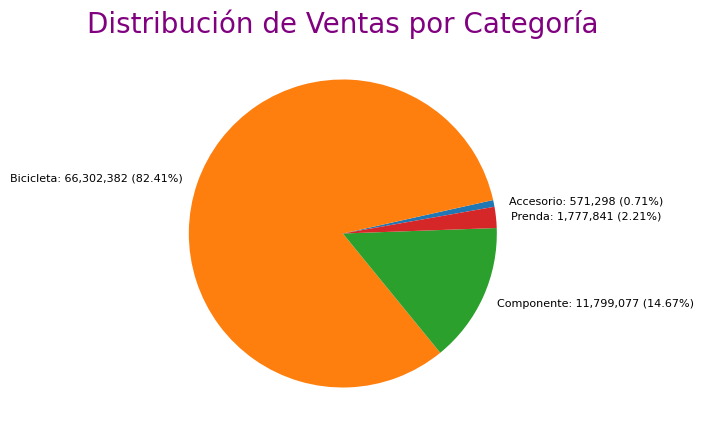

In [ ]:

plt.figure(figsize=(5, 5))
plt.pie(df_categoria_ventas['Ventas'],
        labels=df_categoria_ventas['Etiqueta'],
        textprops={'fontsize':8, 'color':'black'},
        startangle=10)
plt.title('Distribución de Ventas por Categoría', color='purple', fontsize=20)
plt.show()


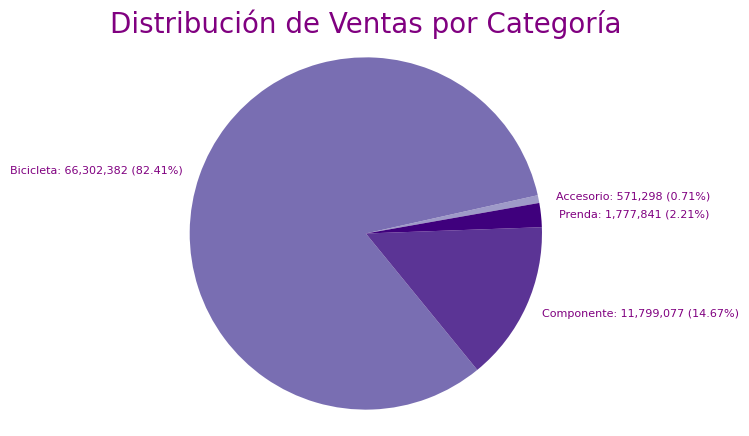

In [ ]:
num_colores = len(categorias)
colores_purpura = plt.cm.Purples(np.linspace(0.5, 1, num_colores))

plt.figure(figsize=(5, 5))
plt.pie(df_categoria_ventas['Ventas'],
        labels=df_categoria_ventas['Etiqueta'],
        colors=colores_purpura,
        textprops={'fontsize':8, 'color':'purple'},
        startangle=10)
plt.title('Distribución de Ventas por Categoría', color='purple', fontsize=20)
plt.axis('equal')
plt.show()

<table width='99%'>
<tr>
<td bgcolor='#FFD43B'>

## **<font color="#000000">Gráficos de dispersión</font>**

</td>
</tr>
</table>

Un gráfico de dispersión es un tipo de visualización que representa datos en dos dimensiones, utilizando puntos para mostrar la relación entre dos variables numéricas.

Cada punto en el gráfico se coloca en función de sus valores en el eje X (horizontal) y el eje Y (vertical).

<table width='99%'>
<tr>
<td bgcolor='#306998'>

### **<font color="#FFFFFF">Características</font>**

</td>
</tr>
</table>

>* **Visualización de Relaciones**: Permiten observar la relación entre dos variables, ayudando a identificar patrones, tendencias y correlaciones.
>* **Detección de Outliers**: Facilitan la identificación de valores atípicos (outliers) que pueden influir en el análisis de datos.
>* **Análisis Exploratorio**: Son herramientas efectivas en el análisis exploratorio de datos (EDA), ya que permiten obtener información inicial sobre la distribución y la relación entre variables.
>* **Modelado de Regresión**: Se utilizan comúnmente para visualizar y analizar modelos de regresión, mostrando cómo los cambios en una variable afectan a otra.
>* **Agrupamiento y Segmentación**: Ayudan a detectar agrupaciones en los datos, lo que puede ser útil en técnicas de segmentación y clustering.
>* **Comparación de Múltiples Grupos**: Se pueden añadir dimensiones adicionales (como color y tamaño) para representar diferentes categorías o grupos dentro del mismo gráfico.

In [ ]:
df_ventas_x_fechas = df_FactVentas.groupby(['Fecha'])['Ventas'].sum().reset_index()
df_ventas_x_fechas.head()

,Fecha,Ventas
0,2010-12-29,4.893286e+05
1,2011-01-29,1.538408e+06
2,2011-03-01,1.165897e+06
3,2011-03-31,8.447210e+05
4,2011-05-01,2.324136e+06


In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(12,6))
plt.scatter(df_ventas_x_fechas['Fecha'], df_ventas_x_fechas['Ventas'], color='purple', s=5, label='Ventas por fecha')
plt.title('Ventas por Fecha', color='purple', fontsize=20)
plt.xlabel('Fecha', color='purple')
plt.ylabel('Ventas', color='purple')
plt.title('Ventas por Fecha', color='purple')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

#plt.legend(title='Leyenda', loc='upper left', frameon=True, facecolor='#ffc5ff', edgecolor='purple', prop={'size': 10, 'family': 'serif', 'weight':'bold'})
plt.legend(title='Leyenda',
           loc='upper left',
           frameon=True,
           facecolor='#ffc5ff',
           edgecolor='purple',
           prop={'size': 10, 'family': 'serif', 'weight':'bold'},
           title_fontproperties={'size': 10, 'family': 'serif', 'weight':'bold'}
           )


plt.gca().spines['top'].set_color('purple')
plt.gca().spines['left'].set_color('purple')
plt.gca().spines['right'].set_color('purple')
plt.gca().spines['bottom'].set_color('purple')

plt.xticks(rotation=90, color='purple', fontsize=6)
plt.yticks(color='purple')
plt.show()

NameError: name 'plt' is not defined